In [ ]:
#######################################################################
#(1) Import Libraries
#######################################################################
import cv2
import numpy as np
import os
import pandas as pd
import skimage.io as io
from skimage.io import imread, imshow, concatenate_images
import matplotlib.pyplot as plt
import skimage.transform as trans
import sys
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.layers import (Input, Dense)
from tensorflow.keras.optimizers import Adam

In [ ]:
#######################################################################
#(2) Import Dataset
#######################################################################
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/building_extraction1"

Confusion_matrix.ipynb	gt_test  test	test.csv  train.csv
DL1401.ipynb		Result	 test2	train


In [ ]:
#######################################################################
#(3) Design and Implementation of the Model (e.g., U-Net, SegNet, etc.)
#######################################################################
#Convolutional Block
############################
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x1 = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="glorot_uniform", dilation_rate=(1, 1), padding="same")(input_tensor)
    if batchnorm:
        x1 = BatchNormalization()(x1)
        x1 = Activation("relu")(x1)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="glorot_uniform", dilation_rate=(1, 1), padding="same")(x1)
    if batchnorm:
        x = BatchNormalization()(x)
    x = concatenate([x1, x])
    x = Activation("relu")(x)
    return x

In [ ]:
#Loss Function
############################
import tensorflow as tf
from keras import backend as K
#weights = tf.constant([0.18, 0.82])
# Create the custom loss function
def weighted_binary_crossentropy(weights):
    def w_binary_crossentropy(train_label, labeled):
        return K.mean(tf.nn.weighted_cross_entropy_with_logits(
            train_label,
            labeled,
            weights,
            name=None
        ), axis=-1)
    return w_binary_crossentropy

In [ ]:
#Model
############################
def model(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # Encoding Path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    # Decoding Path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), dilation_rate=(1, 1), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), dilation_rate=(1, 1), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), dilation_rate=(1, 1), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), dilation_rate=(1, 1), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    c9 = Dropout(dropout)(c9)

    outputs = Conv2D(2, (1, 1), activation='softmax') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model
im_height=512
im_width=512
input_img = Input((im_height, im_width, 3))
model = model(input_img, n_filters=16, batchnorm=True)
weighted_loss = weighted_binary_crossentropy(weights=tf.constant([0.18, 0.82]))
model.compile(optimizer=Adam(lr=0.01, decay=1e-6), loss=weighted_loss, metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 activation_9 (Activation)      (None, 32, 32, 512)  0           ['concatenate_4[0][0]']          
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 64, 64, 128)  589952     ['activation_9[0][0]']           
 ose)                                                                                             
                                                                                                  
 concatenate_5 (Concatenate)    (None, 64, 64, 384)  0           ['conv2d_transpose[0][0]',       
                                                                  'activation_7[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 64, 64, 128)  442496      ['concatenate_5[0][0]']          
                                                                                                  
 batch_nor

In [ ]:
#######################################################################
#(4) Training and Testing
#######################################################################
#Preparing the Training and Testing Dataset
###########################################
path = '/content/drive/My Drive/building_extraction1/'

img_h = 512
img_w = 512
n_labels = 2

n_train = 1434
n_test = 32


def label_map(labels):
    label_map = np.zeros([img_h, img_w, n_labels])
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, labels[r][c]] = 1
    return label_map


def prep_data(mode):
    assert mode in {'test', 'train'}, \
        'mode should be either \'test\' or \'train\''
    data = []
    label = []
    df = pd.read_csv (path + mode + '.csv')
    n = n_train if mode == 'train' else n_test
    for i, item in df.iterrows():
        if i >= n:
            break
        img, gt = [imread(path+item[0])], np.clip(imread(path+item[1]), 0, 1)
        data.append(img)
        label.append(label_map(gt))
        sys.stdout.write('\r')
        sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
                                                    int(100. * (i + 1) / n)))
        sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.flush()
    data, label = np.array(data), np.array(label).reshape((n, img_h, img_w, n_labels))

    print(mode + ': OK')
    print('\tshapes: {}, {}'.format(data.shape, label.shape))
    print('\ttypes:  {}, {}'.format(data.dtype, label.dtype))
    print('\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576))

    return data, label


def plot_results(output):
    gt = []
    df = pd.read_csv(path + 'test.csv')
    for i, item in df.iterrows():
        gt.append(np.clip(imread(path + item[1]), 0, 1))

    plt.figure(figsize=(20, 6 * n_test))
    for i, item in df.iterrows():
        plt.subplot(n_test, 3, 3 * i + 1)
        plt.title('RGB')
        plt.axis('off')
        rgb = imread(path + item[0])
        plt.imshow(rgb)

        plt.subplot(n_test, 3, 3 * i + 2)
        plt.title('Ground Truth')
        plt.axis('off')
        gt = imread(path + item[1])
        plt.imshow(np.clip(gt, 0, 1), cmap='gray')

        plt.subplot(n_test, 3, 3 * i + 3)
        plt.title('Prediction')
        plt.axis('off')
        labeled = np.argmax(output[i], axis=-1)
        plt.imshow(np.clip(labeled, 0, 1), cmap='gray')
        a = np.clip(labeled, 0, 1)
        plt.imsave("/content/drive/My Drive/building_extraction1/Result/{}.png".format(i), a, cmap="gray")

    plt.savefig('/content/drive/My Drive/building_extraction1/Result/results.png')
    plt.show()


In [ ]:
#Training Step
###########################################
train_data, train_label = prep_data('train')
nb_epoch = 2
batch_size = 15
model.load_weights('/content/drive/My Drive/building_extraction1/Result/model_weight_ep69.hdf5')
train_data=train_data.reshape((1434,512,512,3))
results = model.fit(train_data, train_label, batch_size=batch_size, epochs=nb_epoch, validation_split=0.1, shuffle=True)
model.save_weights('/content/drive/My Drive/building_extraction1/Result/model_weight_ep70.hdf5')

train: OK
	shapes: (1434, 1, 512, 512, 3), (1434, 512, 512, 2)
	types:  uint8, float64
	memory: 1075.5, 5736.0 MB
Epoch 1/2
86/86 [==============================] - 2876s 33s/step - loss: 0.4047 - accuracy: 0.9728 - val_loss: 0.4568 - val_accuracy: 0.8513
Epoch 2/2
86/86 [==============================] - 2830s 33s/step - loss: 0.4045 - accuracy: 0.9731 - val_loss: 0.4546 - val_accuracy: 0.8626


In [ ]:
#Trained Model
###########################################
model.load_weights('/content/drive/My Drive/building_extraction1/Result/model_weight_ep70.hdf5')

test: OK
	shapes: (32, 1, 512, 512, 3), (32, 512, 512, 2)
	types:  uint8, float64
	memory: 24.0, 128.0 MB
1/1 [==============================] - 17s 17s/step


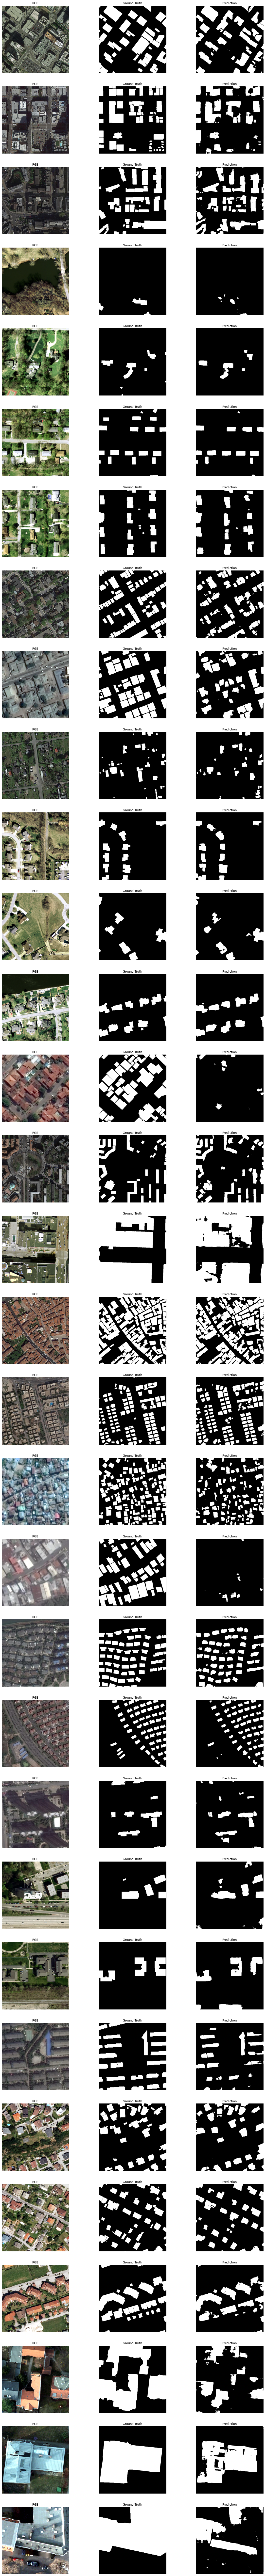

In [ ]:
#Test Step
###########################################
test_data, test_label = prep_data('test')
test_data=test_data.reshape((32,512,512,3))
output = model.predict(test_data, verbose=1)
output = output.reshape((output.shape[0], img_h, img_w, n_labels))
plot_results(output)

In [ ]:
try:
    import pycm
except:
    !pip install -q pycm
    import pycm

     |████████████████████████████████| 66 kB 2.3 MB/s 
     |████████████████████████████████| 592 kB 12.4 MB/s 


In [ ]:
import glob
from tabulate import tabulate
from skimage.io import imread, imshow, concatenate_images
from pycm import *
import numpy as np
import pandas as pd

In [ ]:

test = [cv2.imread(file) for file in glob.glob('/content/drive/MyDrive/building_extraction1/gt_test/*.tif')]
pred = [cv2.imread(file) for file in glob.glob('/content/drive/MyDrive//building_extraction1/Result/*.png')]

y_test    = []
y_pred    = []

for image in test:
  img = image[:, :, 0]
  img = img.flatten()
  y_test.append(img)

for image in pred:
  img = image[:, :, 0]
  img = img.flatten()
  y_pred.append(img)



# importing library
import numpy

# converting list to array
y_test = numpy.array( y_test)
y_pred = numpy.array(y_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
print(y_test.shape)
print(y_pred.shape)

(32, 262144)
(33,)
